<a href="https://colab.research.google.com/github/JackyG38/Confusion-Emotion-Recognition/blob/main/Copy_of_FINAL_Serial_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import  svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving EEGA.csv to EEGA.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['EEGA.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df = df.drop(columns = ['SubjectID', 'VideoID','predefinedlabel'])
#df = df.drop(columns = 'SubjectID')
df.dropna()


Creating sub datasets

In [ ]:
#svm
df1 = df.sample(frac =0.8)

In [ ]:
df1.shape

(10249, 27)

Splitting subset data into train validate and test 

In [ ]:
train_df1, test_df1 = train_test_split(df1, test_size = 0.3, random_state = 113)
#train_df2, test_df2 = train_test_split(df2, test_size = 0.3, random_state = 113)
#train_df3, test_df3 = train_test_split(df3, test_size = 0.3, random_state = 113)
#train_df4, test_df4 = train_test_split(df4, test_size = 0.3, random_state = 113)
#train_df5, test_df5 = train_test_split(df5, test_size = 0.3, random_state = 113)
#train_df6, test_df6 = train_test_split(df6, test_size = 0.3, random_state = 113)




In [ ]:
ic1 = df.columns.tolist() #features
#ic2 = df2.columns.tolist() #features
#ic3 = df3.columns.tolist() #features
#ic4 = df4.columns.tolist() #features
#ic5 = df5.columns.tolist() #features
#ic6 = df6.columns.tolist() #features


In [ ]:
ic1.remove('user-definedlabeln')
oc1 = ['user-definedlabeln'] #target labels

In [ ]:
X_train1 = train_df1[ic1]
y_train1 = train_df1[oc1]
X_test1 = test_df1[ic1]
y_test1 = test_df1[oc1]


In [ ]:
ss = StandardScaler()

X_trs1 = ss.fit_transform(X_train1)
X_tes1 = ss.fit_transform(X_test1)

**TRAINING THE INDEPENDENT CLASSIFIERS WITH OPTIMIZED PARAMETERS**

A) Support Vector Machine

In [ ]:
from sklearn import  svm
svm = SVC(kernel='rbf', C=7, degree = 1, gamma= 'scale', probability = True)
svm.fit(X_trs1,y_train1)
print(f'The accuracy score of the model is {svm.score(X_tes1,y_test1.values.ravel()):.5f}')

B) k Nearest Neighbour

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=120, 
                           weights='distance', 
                           metric='manhattan')
KNN.fit(X_train1,y_train1)
print(f'The accuracy score of the model is {KNN.score(X_test1,y_test1.values.ravel()):.5f}')

C) Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, 
        criterion='entropy', 
        min_samples_split= 4,
        min_samples_leaf= 4, 
        max_depth=10, 
        max_features='log2')
rfc.fit(X_trs1, y_train1)
print(f'The accuracy score of the model is {rfc.score(X_tes1,y_test1.values.ravel()):.5f}')

D) Decision Tree Classifier

In [ ]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_trs1, y_train1)
print(f'The accuracy score of the model is {dtc.score(X_tes1,y_test1.values.ravel()):.5f}')

E) CatBoost Classifier

In [ ]:
pip install catboost

In [ ]:
import catboost

cat = catboost.CatBoostClassifier(iterations= 475,
    learning_rate= 0.027583475549166746,
    depth=4,
    l2_leaf_reg= 1.0551779964424746e-05,
    bootstrap_type='Bayesian',
    random_strength= 2.0931628460945333e-07,
    bagging_temperature= 0.923385947687978,
    od_type='Iter',
    od_wait= 26)
cat.fit(X_trs1, y_train1)
print(f'The accuracy score of the model is {cat.score(X_tes1,y_test1.values.ravel()):.5f}')

F) ADABoost  Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_trs1, y_train1)
print(f'The accuracy score of the model is {ada.score(X_tes1,y_test1.values.ravel()):.5f}')

 G) XGB Classifier

In [ ]:
from xgboost import XGBClassifier
xg1 = XGBClassifier(max_depth= 8,
    learning_rate= 0.01998551759493316,
    n_estimators= 56,
    min_child_weight= 1,
    gamma= 0.000187637803120415,
    subsample= 0.8190504286066517,
    colsample_bytree= 0.6611955891759931,
    reg_alpha= 0.05945438336887176,
    reg_lambda= 2.724508967377622e-05)
xg1.fit(X_trs1, y_train1)
print(f'The accuracy score of the model is {xg1.score(X_tes1,y_test1.values.ravel()):.5f}')

**HETEROGENOUS SERIAL ENSEMBLE MODEL DEVELOPMENT**

A) Calculating Pairwise Disagreement measure

In [ ]:
from sklearn.metrics import accuracy_score

# Define the trained models
models = [svm,KNN,rfc,dtc,cat,ada,xg1]

# Define the prediction function for a single model
def predict_single_model(X, model):
    y_pred = model.predict(X)
    return y_pred

# Define the disagreement function between two models
def disagreement(y_pred1, y_pred2):
    return np.sum(y_pred1 != y_pred2)

# Compute the pairwise disagreements between all models
disagreements = np.zeros((len(models), len(models)))
for i in range(len(models)):
    for j in range(i+1, len(models)):
        y_pred1 = predict_single_model(X_tes1, models[i])
        y_pred2 = predict_single_model(X_tes1, models[j])
        disagreements[i][j] = disagreement(y_pred1, y_pred2)
        disagreements[j][i] = disagreements[i][j]

# Compute the disagreement scores for each model
disagreement_scores = np.sum(disagreements, axis=1)

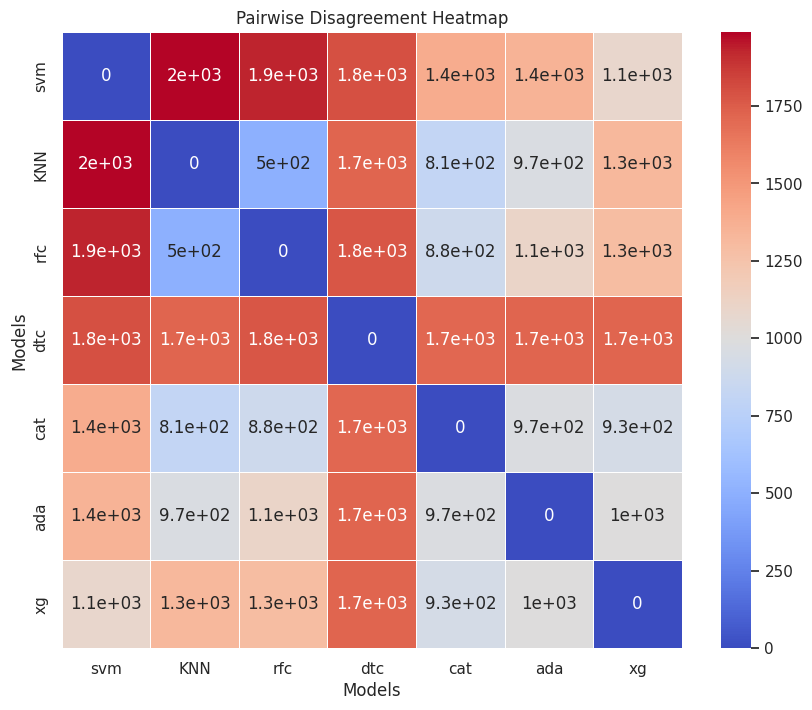

In [ ]:
model_names = [ 'svm','KNN','rfc','dtc','cat','ada','xg']

# Plot the heatmap
sns.set()
fig, ax = plot.subplots(figsize=(10,8))
sns.heatmap(disagreements, cmap="coolwarm", annot=True, linewidths=0.5, ax=ax)

# Replace the tick labels with the model names
ax.set_xticklabels(model_names)
ax.set_yticklabels(model_names)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Models')
ax.set_title('Pairwise Disagreement Heatmap')
plot.show()

B) Development of the 1st sub ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

est_rfc = rfc
#score_kNN=est_XB.fit(X_train,y_train).score(X_test,y_test)

est_knn = KNN
#score_knn=est_knn.fit(X_train,y_train).score(X_test,y_test)

est_Ensemble1 = VotingClassifier(estimators=[('RFC', est_rfc), ('KNN', est_knn)],
                        voting='soft',
                        weights=[1, 1])
est_Ensemble1.fit(X_trs1,y_train1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('RFC', RandomForestClassifier()),
                             ('KNN',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=120,
                                                   weights='distance'))],
                 voting='soft', weights=[1, 1])

In [ ]:
print(f'The accuracy score for the testing dataset is {est_Ensemble1.score(X_tes1, y_test1):.5f}')

The accuracy score for the testing dataset is 0.58923


In [ ]:
# Define the trained models
models1 = [svm,est_Ensemble1,dtc,cat,ada,xg1]

# Define the prediction function for a single model
def predict_single_model(X, model):
    y_pred = model.predict(X)
    return y_pred

# Define the disagreement function between two models
def disagreement1(y_pred1, y_pred2):
    return np.sum(y_pred1 != y_pred2)

# Compute the pairwise disagreements between all models
disagreements1 = np.zeros((len(models1), len(models1)))
for i in range(len(models1)):
    for j in range(i+1, len(models1)):
        y_pred1 = predict_single_model(X_trs1, models1[i])
        y_pred2 = predict_single_model(X_trs1, models1[j])
        disagreements1[i][j] = disagreement1(y_pred1, y_pred2)
        disagreements1[j][i] = disagreements1[i][j]

# Compute the disagreement scores for each model
disagreement_scores = np.sum(disagreements1, axis=1)

In [ ]:
model_names = ['SVM','En1','DTC','Cat', 'ADA','XG']

# Plot the heatmap
sns.set()
fig, ax = plot.subplots(figsize=(10,8))
sns.heatmap(disagreements, cmap="coolwarm", annot=True, linewidths=0.5, ax=ax)

# Replace the tick labels with the model names
ax.set_xticklabels(model_names)
ax.set_yticklabels(model_names)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Models')
ax.set_title('Pairwise Disagreement Heatmap')
plot.show()





Development of the 2nd Ensemble

In [ ]:
est_svm = svm
#score_kNN=est_XB.fit(X_train,y_train).score(X_test,y_test)



est_Ensemble2 = VotingClassifier(estimators=[('En1', est_Ensemble1), ('SVM', est_svm)],
                        voting='soft',
                        weights=[1, 1])
est_Ensemble2.fit(X_trs1,y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('En1',
                              VotingClassifier(estimators=[('RFC',
                                                            RandomForestClassifier()),
                                                           ('KNN',
                                                            KNeighborsClassifier(metric='manhattan',
                                                                                 n_neighbors=120,
                                                                                 weights='distance'))],
                                               voting='soft', weights=[1, 1])),
                             ('SVM', SVC(C=7, degree=1, probability=True))],
                 voting='soft', weights=[1, 1])

In [ ]:
print(f'The accuracy score for the testing dataset is {est_Ensemble2.score(X_tes1, y_test1):.5f}')

The accuracy score for the testing dataset is 0.60276


In [ ]:
# Define the trained models
models1 = [ est_Ensemble2,dtc,cat,ada,xg1]

# Define the prediction function for a single model
def predict_single_model(X, model):
    y_pred = model.predict(X)
    return y_pred

# Define the disagreement function between two models
def disagreement1(y_pred1, y_pred2):
    return np.sum(y_pred1 != y_pred2)

# Compute the pairwise disagreements between all models
disagreements1 = np.zeros((len(models1), len(models1)))
for i in range(len(models1)):
    for j in range(i+1, len(models1)):
        y_pred1 = predict_single_model(X_trs1, models1[i])
        y_pred2 = predict_single_model(X_trs1, models1[j])
        disagreements1[i][j] = disagreement1(y_pred1, y_pred2)
        disagreements1[j][i] = disagreements1[i][j]

# Compute the disagreement scores for each model
disagreement_scores = np.sum(disagreements1, axis=1)

In [ ]:
model_names = ['En2','dtc','cat', 'ada','xg']

# Plot the heatmap
sns.set()
fig, ax = plot.subplots(figsize=(10,8))
sns.heatmap(disagreements, cmap="coolwarm", annot=True, linewidths=0.5, ax=ax)

# Replace the tick labels with the model names
ax.set_xticklabels(model_names)
ax.set_yticklabels(model_names)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Models')
ax.set_title('Pairwise Disagreement Heatmap')
plot.show()


**Development of the 3rd Ensemble**

In [ ]:
est_xg = xg1

est_Ensemble3 = VotingClassifier(estimators=[('En2  ', est_Ensemble2), ('XGBoost', est_xg)],
                        voting='soft',
                        weights=[1, 1])
est_Ensemble3.fit(X_trs1,y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('En2  ',
                              VotingClassifier(estimators=[('En1',
                                                            VotingClassifier(estimators=[('RFC',
                                                                                          RandomForestClassifier()),
                                                                                         ('KNN',
                                                                                          KNeighborsClassifier(metric='manhattan',
                                                                                                               n_neighbors=120,
                                                                                                               weights='distance'))],
                                                                             voting='soft',
                                                                             weights=[1,
                                                                                      1])),
                                                           ('SVM',
                                                            SVC(C=7, degree=1,
                                                                probability=True))],
                                               voting='soft', weights=[1, 1])),
                             ('XGBoost',
                              XGBClassifier(ba...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01998551759493316,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=56, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft', weights=[1, 1])

In [ ]:
print(f'The accuracy score for the testing dataset is {est_Ensemble3.score(X_tes1, y_test1):.5f}')

The accuracy score for the testing dataset is 0.59183


**Development of the 4th Ensemble**

In [ ]:
est_cat = cat

est_Ensemble4 = VotingClassifier(estimators=[('En3', est_Ensemble3), ('CAT', est_cat)],
                        voting='soft',
                        weights=[1, 1])
est_Ensemble4.fit(X_trs1,y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0:	learn: 0.6916433	total: 4.7ms	remaining: 2.23s
1:	learn: 0.6903128	total: 8.82ms	remaining: 2.09s
2:	learn: 0.6889981	total: 12.6ms	remaining: 1.99s
3:	learn: 0.6877997	total: 16.4ms	remaining: 1.93s
4:	learn: 0.6866467	total: 20.3ms	remaining: 1.91s
5:	learn: 0.6854979	total: 24.2ms	remaining: 1.89s
6:	learn: 0.6842945	total: 28.1ms	remaining: 1.88s
7:	learn: 0.6832696	total: 31.9ms	remaining: 1.86s
8:	learn: 0.6822306	total: 35.7ms	remaining: 1.85s
9:	learn: 0.6813357	total: 39.5ms	remaining: 1.83s
10:	learn: 0.6803695	total: 43.4ms	remaining: 1.83s
11:	learn: 0.6793797	total: 47.2ms	remaining: 1.82s
12:	learn: 0.6786277	total: 50.8ms	remaining: 1.8s
13:	learn: 0.6778167	total: 54.7ms	remaining: 1.8s
14:	learn: 0.6769661	total: 58.3ms	remaining: 1.79s
15:	learn: 0.6763769	total: 62ms	remaining: 1.78s
16:	learn: 0.6756077	total: 65.9ms	remaining: 1.77s
17:	learn: 0.6751150	total: 69.6ms	remaining: 1.76s
18:	learn: 0.6743975	total: 73.3ms	remaining: 1.76s
19:	learn: 0.6737932	total:

VotingClassifier(estimators=[('En3',
                              VotingClassifier(estimators=[('En2  ',
                                                            VotingClassifier(estimators=[('En1',
                                                                                          VotingClassifier(estimators=[('RFC',
                                                                                                                        RandomForestClassifier()),
                                                                                                                       ('KNN',
                                                                                                                        KNeighborsClassifier(metric='manhattan',
                                                                                                                                             n_neighbors=120,
                                                                                                                                             weights='distance'))],
                                                                                                           voting='soft',
                                                                                                           weights=[1,
                                                                                                                    1])),
                                                                                         ('SVM',
                                                                                          SVC(C=7,
                                                                                              degree=1,
                                                                                              probability=True))],
                                                                             voting='soft',
                                                                             weights...
                                                                          max_cat_threshold=None,
                                                                          max_cat_to_onehot=None,
                                                                          max_delta_step=None,
                                                                          max_depth=8,
                                                                          max_leaves=None,
                                                                          min_child_weight=1,
                                                                          missing=nan,
                                                                          monotone_constraints=None,
                                                                          n_estimators=56,
                                                                          n_jobs=None,
                                                                          num_parallel_tree=None,
                                                                          predictor=None,
                                                                          random_state=None, ...))],
                                               voting='soft', weights=[1, 1])),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x7f78aee4bf40>)],
                 voting='soft', weights=[1, 1])

In [ ]:
print(f'The accuracy score for the testing dataset is {est_Ensemble4.score(X_tes1, y_test1):.5f}')

The accuracy score for the testing dataset is 0.58117


In [ ]:
est_ada = ada

est_Ensemble5 = VotingClassifier(estimators=[('En3', est_Ensemble4), ('ada', est_ada)],
                        voting='soft',
                        weights=[1, 1])
est_Ensemble5.fit(X_trs1,y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('En3',
                              VotingClassifier(estimators=[('En3',
                                                            VotingClassifier(estimators=[('En1',
                                                                                          VotingClassifier(estimators=[('KNN',
                                                                                                                        KNeighborsClassifier()),
                                                                                                                       ('XG',
                                                                                                                        XGBClassifier(base_score=None,
                                                                                                                                      booster=None,
                                                                                                                                      callbacks=None,
                                                                                                                                      colsample_bylevel=None,
                                                                                                                                      colsample_bynode=None,
                                                                                                                                      colsample_bytree=None,
                                                                                                                                      early_stopping_rounds=None,
                                                                                                                                      enable_categorical=False...
                                                                                                                                      monotone_constraints=None,
                                                                                                                                      n_estimators=100,
                                                                                                                                      n_jobs=None,
                                                                                                                                      num_parallel_tree=None,
                                                                                                                                      predictor=None,
                                                                                                                                      random_state=None, ...))],
                                                                                                           voting='soft',
                                                                                                           weights=[1,
                                                                                                                    1])),
                                                                                         ('RFC',
                                                                                          RandomForestClassifier())],
                                                                             voting='soft',
                                                                             weights=[1,
                                                                                      1])),
                                                           ('RF',
                                                            RandomForestClassifier())],
                                               voting='soft', weights=[1, 1])),
                             ('ada',
                              AdaBoostClassifier(n_estimators=100,
                                      

In [ ]:
print(f'The accuracy score for the testing dataset is {est_Ensemble5.score(X_tes1, y_test1):.5f}')

The accuracy score for the testing dataset is 0.59729


**CONFUSION** **MATRIX**

In [ ]:
y_pred_e2 = est_Ensemble2.predict(X_tes1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1, y_pred_e2)


array([[1057,  806],
       [ 721, 1260]])

In [ ]:
y_pred1 = svm.predict(X_tes1)
confusion_matrix(y_test1, y_pred1)

array([[1135,  728],
       [ 853, 1128]])

In [ ]:
y_pred2 = rfc.predict(X_tes1)
confusion_matrix(y_test1, y_pred2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[  42, 1821],
       [  50, 1931]])

In [ ]:
y_pred3 = KNN.predict(X_tes1)
confusion_matrix(y_test1, y_pred3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[1863,    0],
       [1981,    0]])

In [ ]:
y_pred4 = dtc.predict(X_tes1)
confusion_matrix(y_test1, y_pred4)

array([[1032,  831],
       [ 792, 1189]])

In [ ]:
y_pred5 = cat.predict(X_tes1)
confusion_matrix(y_test1, y_pred4)

array([[1032,  831],
       [ 792, 1189]])

In [ ]:
y_pred6 = xg1.predict(X_tes1)
confusion_matrix(y_test1, y_pred6)

array([[1043,  820],
       [ 509, 1472]])

In [ ]:
y_pred7 = dtc.predict(X_tes1)
confusion_matrix(y_test1, y_pred7)

array([[ 522, 1341],
       [ 376, 1605]])

In [ ]:
y_pred_e1 = est_Ensemble1.predict(X_tes1)
confusion_matrix(y_test1, y_pred_e1)

array([[1027,  836],
       [ 770, 1211]])

In [ ]:
y_pred_e3 = est_Ensemble3.predict(X_tes1)
confusion_matrix(y_test1, y_pred_e3)

array([[ 983,  880],
       [ 689, 1292]])

In [ ]:
y_pred_e4 = est_Ensemble4.predict(X_tes1)
confusion_matrix(y_test1, y_pred_e4)

array([[ 650, 1213],
       [ 397, 1584]])

In [ ]:
y_pred_e5 = est_Ensemble4.predict(X_tes1)
confusion_matrix(y_test1, y_pred_e5)

array([[ 650, 1213],
       [ 397, 1584]])